In [1]:
import tiktoken
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import numpy as np
import os
import json
import time

# Prepare text for training

In [2]:
# Load gpt2 tokenizer
enc = tiktoken.get_encoding('gpt2')
print(f"Vocab size: {enc.n_vocab}") 

# create config dict to keep all params
config = {"sentence_length": 1024,   # max tokens in a sentence
          "batch_tokens": 524_288,   # number of token in one batch, to get one weights update
          "minibatch": 16}           

Vocab size: 50257


In [3]:
from datasets import load_dataset

ds = load_dataset("krvhrv/crawl-books",streaming= True, split="train")

# Check the first 5 book chunck and their length
for n,i in enumerate(ds):   
    print('-----')
    print(i['text'])
    print(f"Number of chars in chunk: {len(i['text'])}")
    if n == 5:
        break 

c:\Users\gianl\python-stuff\python-unleashed 2024\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-----
C O G N I T I V E T H E R A P Y O F S U B S T A N C E A B U S E -•̂ .̂ '̂ ySi:'yf̂ '̂ ''->->*' 'r. ^'i-'Mt .#''a^K"'-M>' • M ^ i € • ̂ ^. M'^::. A A R O N T . B E C K • ^ • r f - F R E D D . W R I G H T C O R Y F . N E W H A N B R U C E S . L I E S E C O G N I T I V E T H E R A P Y O F S U B S T A N C E A B U S E C o g n i t i v e T h e r a p y o f S u b s t a n c e A b u s e Aaron T. Beck, M.D. Fred D. Wright, Ed.D. Cory F. N e w m a n , Ph.D. Bruce S. Liese, Ph.D. T H E G U I L F O R D PRESS N e w York London ©1993 The Guilford Press A Division of Guilford PubHcations, Inc. 72 Spring Street, New York, N Y 10012 www.guilford.com All rights reserved No part of this book may be reproduced, stored in a retrieval s or transmitted, in any form or by any means, electronic, mechanical, photocopying, microfilming, recording, or otherwise, without written permission from the Publisher. Printed in the United States of America. This book is printed on acid-free paper. Last digit is print n

In [ ]:
# the size of the whole dataset is ~4.47GB. 
# Create 20_971_520 token shards --> 512 * 1024 * 40 (batch * tokenlength * batches_per_shard)

def create_shards(text_iterator, 
                  tokenizer,
                  folder:str = None , 
                  shard_length: int = 20_971_520):
    
    """
    Splits a large text dataset into smaller, tokenized shards and saves them as NumPy arrays.
    """
    eot = enc._special_tokens['<|endoftext|>'] # end of text token

    # Create folder if not present
    os.makedirs(folder)
    
    # Function to tokenize text and add endoftext token at the beginning
    def tokenize(text):
         tokens = [eot]
         tokens.extend(tokenizer.encode(text))
         return tokens
    
    new_shard = []
    shard_num = 0
    for i in text_iterator:
            
        # tokenize one text
        tokens = tokenize(i['text'])

        # If the shard has space for the current tokens, add them 
        if len(new_shard)  + len(tokens) <=  shard_length:
            new_shard.extend(tokens)

        # otherwise we fill up the shard,  save it and start a new shard with the remaining tokens
        else:
            new_shard.extend(tokens)

            # Fill and save the previous shard plus one 
            # +1 because X and y are shifted of one tokes:
            # example token length 4, batch size = 2, thus shard size of 8: 
            # x = |1, 2, 3, 4 | 5, 6,7, 8 | --> y = | 2, 3, 4, 5 | 6, 7, 8, 9 |
            # we will save |1, 2, 3, 4, 5, 6, 7, 8, 9 |
            previous_shard = new_shard[:shard_length + 1 ] 
            previous_shard = np.array(previous_shard)
            np.save(os.path.join(folder, 'shard_' + str(shard_num) +  '_.npy'), previous_shard)

            shard_num += 1

            # Create the next shard
            new_shard = new_shard[shard_length:]

In [ ]:
# Create the data                 
create_shards(text_iterator = ds,
              tokenizer = enc,
              folder = "data")

In [3]:
# Class the load one shard at the time and loop through all the shards previously saved
class ShardDataLoader:
    def __init__(self, 
                 folder: str, # where the .npy shards are saved 
                 configdict: dict):
        """
        A data loader for sharded `.npy` files that provides tokenized minibatches for training.

        This class loads sharded `.npy` files containing tokenized text data and yields 
        minibatches of input (x) and target (y) sequences for training.
        """

        self.files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.npy')])
        assert len(self.files)>0 , "No '.npy' files found in the folder."

        # Load the first shard and calculate total number of tokens in the whole dataset
        first_shard = np.load(self.files[0])
        self.shard_tokens = first_shard.shape[0] 
        self.total_dataset_tokens = len(self.files) * (self.shard_tokens - 1)
        print(f"total number of tokens in dataset (billions): {round(self.total_dataset_tokens / 1_000_000_000, 6)} ")

        self.minibatch = configdict["minibatch"]  
        self.tokens_sentence = configdict["sentence_length"] 
        self.minibatch_tokens = self.tokens_sentence * self.minibatch
        self.shard_index = 0
        self.load_shard()

    def load_shard(self):
        file_path = self.files[self.shard_index]
        self.shard = np.load(file_path)
        self.current_location = 0 
         
    def next_batch(self):
        current_batch = self.shard[self.current_location : self.current_location + self.minibatch_tokens + 1]

        x = torch.tensor(current_batch[:-1].reshape(self.minibatch, self.tokens_sentence), dtype= torch.long)
        y = torch.tensor(current_batch[1:].reshape(self.minibatch, self.tokens_sentence), dtype= torch.long)

        # if we are at the end of the shard, load next shard
        if self.current_location + self.minibatch_tokens + 1 == self.shard_tokens:
            
            # if this is the last shard, restart from the first one (index 0)
            if self.shard_index == len(self.files) - 1:
                self.shard_index = 0
            
            # otherwise load next shard in line
            else:
                self.shard_index += 1
            self.load_shard()
        
        else:
            self.current_location += self.minibatch_tokens

        return x, y

In [4]:
text_data = ShardDataLoader(folder = 'data', 
                            configdict = config)

text_data.next_batch()

total number of tokens in dataset (billions): 2.034237 


(tensor([[50256,    34,   440,  ...,  2176,  5895,   286],
         [ 9136, 21403,    11,  ..., 17638,   389, 31349],
         [   13, 30775,    12,  ...,   844,   274, 35592],
         ...,
         [  614,   357, 14874,  ...,    11, 39601,   375],
         [48826,  1127,   357,  ..., 31869,    11,  7016],
         [17087,    11,   290,  ...,   423,   587,  5169]]),
 tensor([[   34,   440,   402,  ...,  5895,   286,  9136],
         [21403,    11,  1390,  ...,   389, 31349,    13],
         [30775,    12,  9662,  ...,   274, 35592, 31458],
         ...,
         [  357, 14874,    86,  ..., 39601,   375, 48826],
         [ 1127,   357, 10508,  ...,    11,  7016, 17087],
         [   11,   290, 23292,  ...,   587,  5169,   329]]))

# GPT2 Model

In [5]:
# Add GPT2 model parameters
config.update({"vocab_size": 50304,    # number of tokens > enc.vocab_size  to avoid ugly numbers
               "layers": 6,            # number of layers
               "heads" :6,             # number of heads
               "embedding_dim" : 384,  # embedding dimension
               "expansion":4,
               "device":"cuda"})

config

{'sentence_length': 1024,
 'batch_tokens': 524288,
 'minibatch': 16,
 'vocab_size': 50304,
 'layers': 6,
 'heads': 6,
 'embedding_dim': 384,
 'expansion': 4,
 'device': 'cuda'}

In [6]:
# GPT2 model 
class GPT2(nn.Module):
    """
    This class implements a decoder only GPT2 model for text generation. 
    It includes token and positional embeddings, multiple transformer blocks, 
    layer normalization, and a final linear layer for token classification.
    """
    def __init__(self, configdict):
        super().__init__()
        self.configdict  = configdict

        self.positional_embedding = nn.Embedding(configdict["sentence_length"], configdict["embedding_dim"])
        self.word_embedding = nn.Embedding(configdict["vocab_size"], configdict["embedding_dim"])

        self.transformerblocks = nn.ModuleList([TransformerBlock(configdict) for _ in range(configdict["layers"])])
        self.final_layer_norm = nn.LayerNorm(configdict["embedding_dim"])

        self.linear_head = nn.Linear(configdict["embedding_dim"], configdict["vocab_size"], bias=False)

        # share weights between embedding layer and final head layer
        self.word_embedding.weight = self.linear_head.weight  

    def forward(self, tokens):
        B, seq_len = tokens.size()

        # forward the token and position embeddings
        positions = torch.arange(0, seq_len, dtype=torch.long, device=self.configdict["device"]) # shape (seq_len)
        pos_emb = self.positional_embedding(positions) # position embeddings of shape (seq_len, embedding_dim)
        tok_emb = self.word_embedding(tokens)      # token embeddings of shape (B, seq_len, embedding_dim)
        x = tok_emb + pos_emb
        # print(x.shape)
        # forward the blocks of the transformer
        for block in self.transformerblocks:
            x = block(x)
        # Final layernorm classifier
        x = self.final_layer_norm(x) # (B, seq_len, embedding_dim)

        # Classifier
        out = self.linear_head(x) # (B, seq_len, vocab_size)
        
        return out


class TransformerBlock(nn.Module):

    """
    A single transformer block containing self-attention and feed-forward layers.

    This block applies self-attention to capture dependencies between tokens
    and a feed-forward network to refine the representation.
    """

    def __init__(self, configdict):
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(configdict["embedding_dim"])
        self.attention = SelfAttention(configdict)
        self.layer_norm_2 = nn.LayerNorm(configdict["embedding_dim"])

        self.FFN = nn.Sequential(
            nn.Linear(configdict["embedding_dim"], configdict["expansion"] * configdict["embedding_dim"]),
            nn.GELU(approximate='tanh'),
            nn.Linear(configdict["expansion"] * configdict["embedding_dim"], configdict["embedding_dim"]))

    def forward(self, x):
        x = x + self.attention(self.layer_norm_1(x))
        x = x + self.FFN(self.layer_norm_2(x))

        return x

class SelfAttention(nn.Module):
    """
    A multi-head self-attention mechanism for processing input sequences.

    This class implements scaled dot-product attention, allowing the model 
    to focus on relevant parts of the input sequence.
    """
    def __init__(self, configdict):
        super().__init__()
        assert configdict["embedding_dim"] % configdict["heads"] == 0

        # Linear layer to make q, k, v indipendent from each other (separate weigths)
        self.qkv = nn.Linear(configdict["embedding_dim"], 3 * configdict["embedding_dim"])
        self.linear = nn.Linear(configdict["embedding_dim"], configdict["embedding_dim"])

        self.n_head = configdict["heads"]
        self.embedding_size = configdict["embedding_dim"]
        self.head_dim = configdict["embedding_dim"] // configdict["heads"]
    
    def forward(self, x):
        B, seq_len, embed_size = x.size()

        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        qkv = self.qkv(x) #(B, seq_len,  embed_size * 3  )  # CHECK 

        q, k, v = qkv.split(self.embedding_size, dim=2)  # each with dim (B, seq_len, embed_size)
        k = k.view(B, seq_len, self.n_head , self.head_dim)    # (B, seq_len, n_head, head_dim ) 
        k = k.transpose(1, 2) # (B, nh, T, hs)                 # (B, n_head, seq_len, head_dim ) 

        q = q.view(B, seq_len, self.n_head , self.head_dim)    # (B, seq_len, n_head, head_dim ) 
        q = q.transpose(1, 2)                                  # (B, n_head, seq_len, head_dim )  

        v = v.view(B, seq_len, self.n_head , self.head_dim)    # (B, seq_len, n_head, head_dim ) 
        v = v.transpose(1, 2)                                  # (B, n_head, seq_len, head_dim ) 

        att = F.scaled_dot_product_attention(q, k, v, is_causal=True)
        out = att.transpose(1, 2).contiguous().view(B, seq_len, embed_size)  # (B, seq_len, embed_size )
        out = self.linear(out) # (B, seq_len, embed_size )

        return out

# Func to count the total number of parameters
def countparams(model):
    print(f"Number of params (millions): {sum(p.numel() for p in model.parameters()) / 1_000_000}")

In [7]:
# Instantiate the model
model = GPT2(config)
countparams(model)

# push the model to device - GPU
model.to(config["device"])

# Generate some randome data
data = torch.randint(low = 0, high  = 255, size =(2, config["sentence_length"])).to('cuda')

# Make predictions to confirm the output shape
model.eval()
preds = model(data)
print(f"Prediction's shape: {preds.shape}\n")
print("Predictions:")
print(preds)

Number of params (millions): 30.357504
Prediction's shape: torch.Size([2, 1024, 50304])

Predictions:
tensor([[[-0.3278, -0.9009,  0.5337,  ..., -0.0034,  0.3910, -0.2300],
         [-0.8126, -0.0474,  0.1960,  ...,  0.0995, -0.3874, -0.1712],
         [ 0.1613, -0.8689,  0.4665,  ..., -0.5322, -0.0394, -0.5737],
         ...,
         [-0.0822,  0.2822,  0.0504,  ...,  0.0187, -0.3526, -0.0869],
         [ 0.8699,  0.0215,  1.5261,  ..., -0.5282,  0.2083, -0.2048],
         [ 0.5194, -0.7412, -1.2242,  ..., -0.2702,  0.3583, -0.5710]],

        [[-0.3718, -0.8887,  0.5207,  ..., -0.0240,  0.4006, -0.2496],
         [-0.8228, -0.0212,  0.1990,  ...,  0.0722, -0.3760, -0.1283],
         [ 0.1561, -0.8966,  0.4493,  ..., -0.5232, -0.0344, -0.5551],
         ...,
         [-0.1117,  0.2894,  0.0379,  ...,  0.0235, -0.3550, -0.1156],
         [ 0.8474,  0.0066,  1.5459,  ..., -0.5422,  0.2246, -0.2060],
         [ 0.5110, -0.7417, -1.2047,  ..., -0.2773,  0.3538, -0.5591]]],
       device=

C:\Users\gianl\AppData\Local\Temp\ipykernel_7932\4127448139.py:106: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  att = F.scaled_dot_product_attention(q, k, v, is_causal=True)


# Model Training 

In [8]:
from torch.optim import AdamW

def train(model,
          tokens_train_goal, # how tokens to train the model on
          train_loader,
          optimizer,
          loss_func,
          config_dict,
          path = None):  # where to save trained model and config dict
    
    model.train()     
    train_loss = []
    tokens_trained = 0
    steps = 0
    # minibatch = config_dict["minibatch"]

    # number of minibatched to get to batch_tokens ~0.5M tokens
    minibatches_for_full_batch = int(config_dict['batch_tokens'] / (config_dict['minibatch'] * config_dict['sentence_length']))
    # print(minibatches_for_full_batch)

    while tokens_trained < tokens_train_goal: 
        batch_loss = 0 
        optimizer.zero_grad()
        start = time.time()
        # accumulate gradient for 512 rows (~500M tokens) before updating weight 
        for _ in range(minibatches_for_full_batch):
            X, y = train_loader.next_batch()
            tokens_trained += X.numel() # update the total number of tokens the model has been trained on

            X = X.to(config["device"])
            y = y.to(config["device"])
            with torch.autocast(device_type = config["device"],
                                dtype = torch.bfloat16):
                                
                preds = model(X)

                # change y and prediciton shape for loss calculation
                y =  y.view(-1)
                preds = preds.view(-1, preds.size(-1))

                loss = loss_func(preds, y)
            batch_loss += loss.detach().cpu().numpy() 

            # accumulate the gradient every minibatch
            loss.backward()

        train_loss.append(round(batch_loss, 4))

        # update model's weight, every 512 rows
        optimizer.step()
        deltatime =  time.time() - start
        steps += 1
        print(f"step {steps} --- loss {train_loss[-1]} --- time {round(deltatime, 3)} seconds --- total tokens {tokens_trained}")

    # plot train loss
    plt.plot(range(steps) , train_loss)
    plt.title('Train loss')
    plt.xlabel('steps')
    plt.ylabel('loss')
    plt.show()

    # save model and config dict
    if path != None:
        if not os.path.exists(path):
            os.makedirs(path)
        torch.save(model.state_dict(), path + "/model_weights.pth")

        with open(path + "/config.json", "w") as f:
            json.dump(config_dict, f, indent=4)  # `indent=4` makes it more readable

    return model

Number of params (millions): 37.460736
total number of tokens in dataset (billions): 2.034237 
step 1 --- loss 351.6043 --- time 4.973 seconds --- total tokens 524288
step 2 --- loss 346.5694 --- time 4.831 seconds --- total tokens 1048576
step 3 --- loss 340.3955 --- time 4.7 seconds --- total tokens 1572864
step 4 --- loss 337.6943 --- time 4.783 seconds --- total tokens 2097152
step 5 --- loss 334.9453 --- time 4.679 seconds --- total tokens 2621440
step 6 --- loss 330.769 --- time 4.721 seconds --- total tokens 3145728
step 7 --- loss 328.0908 --- time 4.708 seconds --- total tokens 3670016
step 8 --- loss 322.0426 --- time 4.692 seconds --- total tokens 4194304
step 9 --- loss 320.0319 --- time 4.692 seconds --- total tokens 4718592
step 10 --- loss 321.7034 --- time 4.719 seconds --- total tokens 5242880
step 11 --- loss 320.1015 --- time 4.697 seconds --- total tokens 5767168
step 12 --- loss 314.7404 --- time 4.699 seconds --- total tokens 6291456
step 13 --- loss 314.104 --- t

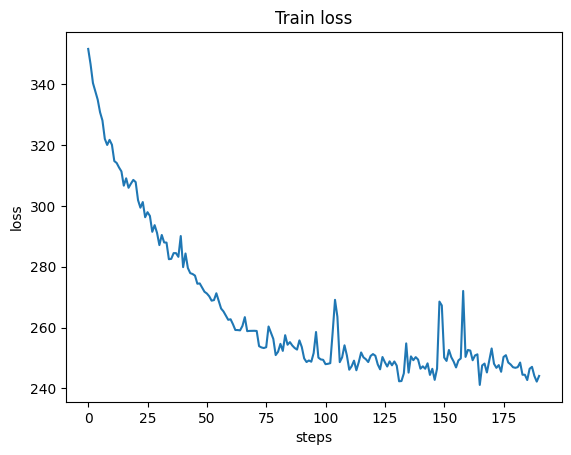

In [10]:
# update config files
config.update({"vocab_size":50304,    # number of tokens > enc.vocab_size  to avoid ugly numbers
               "layers":12,            # number of layers
               "heads":12,            # number of heads
               "embedding_dim":384,  # embedding dimension
               "expansion":3,
               "device":"cuda",
               "minibatch":16})

# set lower precision
torch.set_float32_matmul_precision('high')

# instantiate the model
model = GPT2(config)
countparams(model)

# send model to device
model.to(config["device"])

# create data loader
data_loader = ShardDataLoader(folder = 'data', 
                              configdict = config)

trained_model = train(model=model,
                      tokens_train_goal = 100E+6,
                      train_loader = data_loader,
                      optimizer = AdamW(model.parameters(), lr = 0.0001),
                      loss_func = nn.CrossEntropyLoss() ,
                      config_dict= config,
                      path = "37M params" )

# Load Model and Generate text

In [11]:

# function to load trained model and config file 
def load_model(path): # path to folder where trained model and config file are saved 
    with open(path+"/config.json", "r") as f:
        configfile = json.load(f)

    model = GPT2(configfile)
    model.load_state_dict(torch.load(path+"/model_weights.pth"))
    return model, configfile

trained_model, config_file = load_model("37M params")

In [13]:
# function to generate text given a short seed text
def generate(seed_text : str, 
             model, 
             tokenizer,
             config_dict):
    
    model.to(config_dict["device"])
    model.eval()
    tokens_seed = tokenizer.encode(seed_text)
    tokens_seed_length = len(tokens_seed)

    eos = enc._special_tokens['<|endoftext|>']
    tokens_base = [eos] * config_dict['sentence_length']

    tokens_base[1: tokens_seed_length + 1] = tokens_seed

    tokens_seed = torch.tensor(tokens_base, device=config_dict["device"]).unsqueeze(0)

    # print(tokens_seed.shape)
    while tokens_seed_length  + 1 <  config_dict['sentence_length'] : 
        pred = model(tokens_seed)
    
        probs = F.softmax(pred[:, tokens_seed_length-1,:].squeeze())
        # print(probs.shape)
        topk_p, topk_index = torch.topk(probs, 20, dim = -1)
        # print(topk_index)
        ix = torch.multinomial(topk_p, 1)
        # print(ix)
        new_tok = topk_index[ix]
        # print(new_tok)
        tokens_seed[:,tokens_seed_length+1] = new_tok
        # print(tokens_seed[:,tokens_seed_length- 5: tokens_seed_length + 5])

        tokens_seed_length += 1


    # print(tokens_seed)
    print(enc.decode(tokens_seed[0].detach().cpu().numpy()))


        
generate(seed_text = """In the maintenance stage individuals""",
         model = trained_model,
         tokenizer= enc,
         config_dict= config_file)

C:\Users\gianl\AppData\Local\Temp\ipykernel_7932\455598246.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(pred[:, tokens_seed_length-1,:].squeeze())


<|endoftext|>In the maintenance stage individuals the is, with al the to with;; (– of: in; in the in et-, al. of). to the. is. et al)). al of of). ()... for. in and of for the a. with., of with in is of in and of for.,., al al (). ( ( and; the ( the,.,.:, the (. a a.. the, for is the, is al. the (, the et a.. the a., is. in-,. the:,. to with and,).. a and:.;)- and,- to a,) and. al of the al the-, the; with. ( the, al) the- of (,. al- the,. and a to,. of in al,, the and ( ( a,-, for a. to (,. in the the a... a, with to and ( and al al,, et. et–,, in). the for the)... or a to of. and for. (. et in:; in in and:, al (. and,) the of a in al, with. for. al for (. the, the. and. and, et-- is and to,, to. to.,,) in the. and ( al al with a., with and for of,; with al and. with;,. in in. and ( of.;. of the, the.. is is The ( of in of, et with of- a and a and (, to... and and a ( with).. a-)..-.,,,. the the for. for. and– and.:, to with).. of is,- the; al)..;. in with;); et ( the et is. to, al,,.